Begin by reading in all required libraries. You may have to install these.

In [2]:
import sys, multiprocessing, csv
import numpy as np
import pandas as pd
import keras
import cv2
from matplotlib import pyplot as plt
import os
import random
from urllib.request import urlopen
from io import BytesIO
from PIL import Image
from sklearn.preprocessing import LabelEncoder


# Deep Learning libraries
import tensorflow.keras as keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD

Import the data sets. These are found in the 'google-data' folder. I downloaded these straight from Kaggle.

In [3]:
df = pd.read_csv("google-data/train.csv")
num_classes = len(df["landmark_id"].unique())
num_data = len(df)

df = df[df.landmark_id!='None'] # Removing any unlabeled images

In [4]:
df.head()

,id,url,landmark_id
0,97c0a12e07ae8dd5,http://lh4.ggpht.com/-f8xYA5l4apw/RSziSQVaABI/...,6347
1,650c989dd3493748,https://lh5.googleusercontent.com/-PUnMrX7oOyA...,12519
2,05e63ca9b2cde1f4,http://mw2.google.com/mw-panoramio/photos/medi...,264
3,08672eddcb2b7c93,http://lh3.ggpht.com/-9fgSxDYwhHA/SMvGEoltKTI/...,13287
4,fc49cb32ef7f1e89,http://lh6.ggpht.com/-UGAXxvPbr98/S-jGZbyMIPI/...,4018


In [5]:
print("Size of training data:", df.shape)
print("Number of unique classes:", num_classes)

Size of training data: (1154202, 3)
Number of unique classes: 14945


In [6]:
data = pd.DataFrame(df['landmark_id'].value_counts())

#index the data frame
data.reset_index(inplace=True) 
data.columns=['landmark_id','count']
print(data.head(10))
print(data.tail(10))

  landmark_id  count
0        9633  48550
1        6051  47825
2        6599  21777
3        9779  17601
4        2061  12742
5        5554  10302
6        6651   8950
7        5376   8893
8        6696   8885
9        4352   8689
      landmark_id  count
14934        7933      1
14935        1913      1
14936       10535      1
14937        6423      1
14938        9559      1
14939        8309      1
14940        5030      1
14941        3022      1
14942       14180      1
14943        7977      1


count    14944.000000
mean        77.235145
std        675.090417
min          1.000000
25%          6.000000
50%         13.000000
75%         43.000000
max      48550.000000
Name: count, dtype: float64


Text(0, 0.5, 'Occurences')

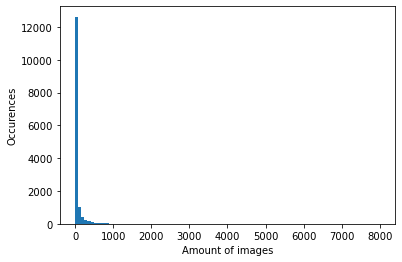

In [7]:
print(data['count'].describe())#statistical data for the distribution
plt.hist(data['count'],100,range = (0,8000),label = 'test')#Histogram of the distribution
plt.xlabel("Amount of images")
plt.ylabel("Occurences")

In [8]:
print("Amount of classes with less than or equal to five datapoints:", (data['count'].between(0,5)).sum()) 
print("Amount of classes between five and 10 datapoints:", (data['count'].between(5,10)).sum())

Amount of classes with less than or equal to five datapoints: 3592
Amount of classes between five and 10 datapoints: 4421


It looks like the majority of classes have few occurances. Let's see how many images are left in our training set when we put a bound on the required number of images per class.

In [9]:
# Finding number of classes with more than 10 images
above10 = data[data['count']>10]
len(above10)

8240

In [10]:
# Subsetting training data to images in classes with >10 images
df_above10 = df[df['landmark_id'].isin(above10['landmark_id'])]
len(df_above10)

1116911

This is still over a million images, which is infeasible for us to use unless we want to use some cloud service and spend >20 hours downloading all the images (number taken from this article: https://medium.com/@abhinaya08/google-landmark-recognition-274aab3c71ae).

To put in perspective how many classes have a huge number of images, we still have about 250k images when we restrict the traing dataset to those in classes with over 4,000 images. This would take around 6 hours to download. That is doable, but still annoying.


### Subsetting images considerations

Some thoughts on how to subset images:

- Dealing with imbalanced data is annoying--having a training dataset with one class that has 100 images and another with 5000 images will lead to our classification model poorly predicting images of the former class. I vote we stick to classes with a somewhat equal amount of images. So for example we only keep images in classes where the number of images is something in the range of [750,1000].
    
- One option could be to take the first N instances of images in each class. So for example we keep all images in classes with over 100 images, but if the class has over 100 images, we only take the first 100 images from that class. That is a way of balancing our data, but personally I don't feel it's necessary since we have already a ton of classes in the example range I set above. It could also lead to unwanted bias in our results since we're arbitrarily removing images.

In [11]:
# Subsetting the training data to fit the example range of (classes in [750,1000])

exRange = data[data['count'].between(750,1000)]
print(len(exRange))

df_exRange = df[df['landmark_id'].isin(exRange['landmark_id'])]
print(len(df_exRange))

78
66040


We have 78 classes in which the number of images is in the range of (750,1000). This results in 66,040 images in total when we restrict the training data to only images in those classes. This is feasible.

### Test data considerations

Now an important thing to note is that test.csv contains UNLABELED data, as this dataset is used for a Kaggle competition and thus contestants are not given ground truth for the test samples.

In fact the link that Mark provided from analyticsvidhya does not produce any test error at all--if you look at their code under the sentence "Our next step is to test the model, let’s see the results of our trained landmark detection model:", you'll see that they're predicting the training images to calculate the error.

Because we do not have the ground truth of images in test.csv, we'll have to manually split our training data into training/validation/test sets. This is super easy and is actually kind of nice because we know for certain our test images are in the same classes as our training images.

## Downloading images

I want to make sure we can successfully download the 66,040 images we need. Based on my estimates this would still require some 10-14 GBs which my tiny mac cannot handle. I'm going to make the problem even smaller just to see if I can get the images donwloaded.

In [12]:
# Subsetting the training data to fit in an even SMALLER range of (900,950)

smallRange = data[data['count'].between(900,950)]
print(len(smallRange))

df_smallRange = df[df['landmark_id'].isin(smallRange['landmark_id'])]
print(len(df_smallRange))

# This yields 12 classes and just over 10k images. Let's see if it works.

12
10979


In [13]:
# Checking to see where I am in my system
# os.getcwd()

In [14]:
# Writing csv of this small subset of images
#df_smallRange.to_csv('google-data/train_subset.csv', index=False)

After running my modified version of the download file I was able to get 10,353 of the images. The rest were broken links. This took about 45 minutes to download and around 6GB of storage. If we want to use more images I'll definitely have to use a cloud system because I only have 4GB left on my computer.

## Training model

In [15]:
df = df_smallRange

4 sample images from random classes:


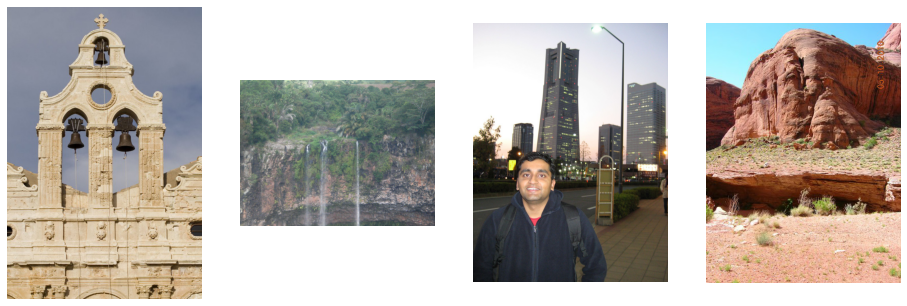

In [16]:
print("4 sample images from random classes:")
fig=plt.figure(figsize=(16, 16))
for i in range(1,5):
    folder = '/Users/margaretsabelhaus/Documents/GitHub/CSCI575-Group12/example-project/google-data/images'
    random_img = random.choice(os.listdir(folder))
    img = np.array(Image.open(folder+'/'+random_img))
    fig.add_subplot(1, 4, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [17]:
# Copying this example model directly from analyticsvidhya article

# Parameters
learning_rate   = 0.0001
decay_speed     = 1e-6
momentum        = 0.09
loss_function   = "sparse_categorical_crossentropy"
source_model = VGG19(weights=None)
#new_layer = Dense(num_classes, activation=activations.softmax, name='prediction')
drop_layer = Dropout(0.5)
drop_layer2 = Dropout(0.5)
model = Sequential()
for layer in source_model.layers[:-1]: # go through until last layer
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)
#     if layer == source_model.layers[-3]:
#         model.add(drop_layer)
# model.add(drop_layer2)
model.add(Dense(num_classes, activation="softmax"))
model.summary()
optim1 = keras.optimizers.RMSprop(learning_rate = 0.0001, momentum = 0.09)
optim2 = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=optim1,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
sgd = SGD(lr=learning_rate, decay=decay_speed, momentum=momentum, nesterov=True)
rms = keras.optimizers.RMSprop(learning_rate=learning_rate, momentum=momentum)
model.compile(optimizer=rms,
              loss=loss_function,
              metrics=["accuracy"])
print("Model compiled! n")

2022-03-29 08:47:19.075344: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 224, 224, 3)       12        
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0

/Users/margaretsabelhaus/opt/anaconda3/envs/dsci/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [22]:
# Trying to get list of image files
my_list = os.listdir('google-data/images')

In [26]:
my_list = [s.strip('.jpg') for s in my_list]
my_list

['ca40b8cf79e2b41d',
 '140de71a39dec73f',
 '9a53af8cb2a27d0d',
 'c2f641e5b94b3a84',
 '8082a3e185a6b1ef',
 '28ebd4f09dbb1488',
 'cc48c07a00647a41',
 '4907b8e1e54f3a09',
 '8cae258be62149fd',
 '1073ae135a62daad',
 '7a5575e77f62c9bc',
 'e3f175eacfcffa73',
 '8d156c2f83bb8cff',
 '41725c45e3581cd7',
 '380687565ce6a853',
 '63c636c689a0afd4',
 '8f6981c1dcc8bffd',
 'f26e879d8a910f7a',
 'ec56654756ea53d7',
 '1115453cd3b92625',
 '463ca80404807347',
 'fc4501cbfff8b929',
 '7c3af45673e740e0',
 'd4996dabd72d6468',
 '598acb32c79fafd0',
 'e8c3446bdf167699',
 'b9cc1853219d75b4',
 '28f95ffa0104e24b',
 '50ba8082ca448dcd',
 '4872c29f6c2b4cdc',
 '854f66424c67ff24',
 '485e93198a599daa',
 '67830f05ebcd58a4',
 'd23a3f3ac721c138',
 '72652ccf4ca8a5d0',
 '5fa69f8052a3709c',
 'fcd448eeadd0520f',
 '7901255e0a715287',
 '895259105cd808be',
 '01e0fa7d2f4705d3',
 '973fd3f2bb23fa1a',
 '3e9d5fa894774122',
 '87564d15483a0af1',
 'd218a60a77445bea',
 'b26e77bad22a2c98',
 '6c73f2e84791991b',
 'bd20338bb3cfe17f',
 'da2bbceec75

In [30]:
#Function used to process the data, fitted into a data generator.

# Manually setting path
folder = '/Users/margaretsabelhaus/Documents/GitHub/CSCI575-Group12/example-project/google-data/images'

lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])
def encode_label(lbl):
    return lencoder.transform(lbl)
def decode_label(lbl):
    return lencoder.inverse_transform(lbl)
def get_image_from_number(num, df):
    #print(df.iloc[num,:])
    row = df.iloc[num,:]
    #print(row[0])
    #print(row[2])
    #fname, label = df.iloc[num,:]
    fname = row[0]
    label = row[2]
    fname = fname + ".jpg"
    path = os.path.join(folder,fname)
    im = cv2.imread(path)
    
    # // Error handling
    print(im.shape)
    # 2.28 spotted the issue: we're trying to read in images that do not exist.
    # The main DF references all images. However, we were unable to download some where the url was broken.
    # Not sure of any easy solutions.
    
    return im, label
def image_reshape(im, target_size):
    return cv2.resize(im, target_size)
def get_batch(dataframe,start, batch_size):
    image_array = []
    label_array = []
    end_img = start+batch_size
    if end_img > len(dataframe):
        end_img = len(dataframe)
    for idx in range(start, end_img):
        n = idx
        im, label = get_image_from_number(n, dataframe)
        im = image_reshape(im, (224, 224)) / 255.0
        image_array.append(im)
        label_array.append(label)
    label_array = encode_label(label_array)
    return np.array(image_array), np.array(label_array)
batch_size = 16
epoch_shuffle = True
weight_classes = True
epochs = 15

# Split train data up into 80% and 20% validation
train, validate = np.split(df.sample(frac=1), [int(.8*len(df))])
print("Training on:", len(train), "samples")
print("Validation on:", len(validate), "samples")
for e in range(epochs):
    print("Epoch: ", str(e+1) + "/" + str(epochs))
    if epoch_shuffle:
        train = train.sample(frac = 1)
    for it in range(int(np.ceil(len(train)/batch_size))):
        X_train, y_train = get_batch(train, it*batch_size, batch_size)
        
        # // Error handling
        #print(X_train)
        #print(y_train)
        # We seem to be able to read in the data fine
        
        model.train_on_batch(X_train, y_train)
#model.save("Model.h5")

Training on: 8783 samples
Validation on: 2196 samples
Epoch:  1/15
(1200, 1600, 3)
(1200, 1600, 3)
(1200, 1600, 3)
(1200, 1600, 3)
(664, 1000, 3)
(682, 1024, 3)
(1200, 1600, 3)
(1600, 1200, 3)
(512, 382, 3)
(1600, 1064, 3)
(1200, 1600, 3)
(566, 849, 3)
(1200, 1600, 3)
(1071, 1600, 3)
(1200, 1600, 3)
(683, 1024, 3)
(1600, 1063, 3)


AttributeError: 'NoneType' object has no attribute 'shape'

In [31]:
# One solution: write some sort of function...
# IF [id in df] NOT IN [..../image_folder], THEN [remove sample]

,id,url,landmark_id
168533,99be564fce302eba,http://lh4.ggpht.com/-vNYJJZYUO4E/TAFNFRPNeaI/...,12075
935996,53f1aa29c2d9cb40,http://lh3.ggpht.com/-WsSrZXDHbXw/SL7M7l_y_SI/...,12075
812659,fd9697cc22ee3860,https://lh6.googleusercontent.com/-qNu8u8SN5yY...,12965
275910,c22e81e400519ff0,https://lh6.googleusercontent.com/-Z9NYddeN_9Q...,253
58693,aa044b946d2f34ce,https://lh3.googleusercontent.com/-bIOI12Jy-8w...,10313
...,...,...,...
342975,a33fc4bde2aeba38,https://lh6.googleusercontent.com/-MVYAsYfGUDs...,12075
615975,5cb1d45e7798ecfb,http://lh5.ggpht.com/-JELyxwlrMQU/Sv_sr6lK1sI/...,6973
166501,9f0b9c3bf0e6d1c9,https://lh5.googleusercontent.com/-ApY3JnHDBLs...,9738
316188,2bb5e3592234bcde,http://lh6.ggpht.com/-TGA_5ipyfjc/SqBmCnnPUzI/...,253


In [26]:
# Manually setting path
folder = '/Users/margaretsabelhaus/Documents/GitHub/CSCI575-Group12/example-project/google-data/images'

# choosing random number
num = 4

# Below is content from get_image_from_number() function
row = df.iloc[num,:]
fname = row[0]
label = row[2]
fname = fname + ".jpg"
path = os.path.join(folder,fname)
im = cv2.imread(path)

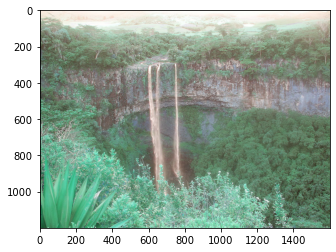

In [27]:
plt.imshow(im)